<!-- TITLE -->
<h3 align='center'> <em> Deep Learning for Financial Time Series </em> </h3>
<!-- <h2 align='center'> Deep Learning </h2> -->
<h3 align='center'> Short Term Trend Prediction </h3>
<h4 align='center'> Filipe Papa de Figueiredo </h4>
<h4 align='center'> August 21, 2023 </h4>


- - - 

## Imports

In [1]:
#%%
# pip install numpy==1.19.5 matplotlib==3.3.3 streamlit==0.74.1 scipy==1.7.0 tensorflow==2.6 tensorboard==2.6 keras==2.6 keras-tuner==1.0.3 protobuf==3.19.6
# basic imports
import os, random
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
import pandas_ta as ta
from pathlib import Path
from collections import Counter
# import boruta
from boruta import BorutaPy

# warnings
import warnings
warnings.filterwarnings('ignore')

# plotting & outputs
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn')
plt.style.use('default')
mpl.rcParams['figure.figsize'] = [10.0, 6.0]
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.grid'] = True

# functions from helper
# from src.tools import *

# import custom transformer
# from helper import DayTransformer, TimeTransformer

# statsmodels
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pyfolio as pf


# sklearn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, plot_roc_curve


# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2
from minisom import MiniSom

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.layers import LSTM, BatchNormalization

# kerastuner
import keras_tuner as kt
from kerastuner import HyperParameter, HyperParameters
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

## Functions and Classes

In [2]:

def set_seeds(seed=42): 
    '''define seed'''
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def cwts(dfs):
    '''class weight function'''
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}

def plot_ft(df:pd.DataFrame,lst_plot=None,overlay=True,figsize=(20,15),lw=1,xdate=True):
    '''plot features'''
    df.dropna(inplace=True)
    if lst_plot==None:
        fig, axs = plt.subplots(df.shape[1], sharex=True, figsize=figsize) # (20,150) for all features
        if xdate:
            for i,f in enumerate(df.columns): 
                axs[i].plot(df.index, df.iloc[:,i],label=f,linewidth=lw);
                axs[i].legend(loc="lower right");
        else:
            for i,f in enumerate(df.columns): 
                axs[i].plot(list(range(df.shape[0])), df.iloc[:,i],label=f,linewidth=lw);
                axs[i].legend(loc="lower right");
    else:
        chart = df[lst_plot]
        if overlay:
            chart.plot(use_index=0)
            plt.legend(lst_plot);
        else:
            plt.subplot(2,1,1)
            df['Close'].plot(use_index=0,legend=True)
            # plt.legend('Close')
            lst_plot.remove('Close')
            plt.subplot(2,1,2)
            plt.plot(df[lst_plot].values)
            plt.legend(lst_plot);

def plot_confusion_matrix(y_test,y_pred,title=None,normalize='true',figpath=''):
    '''plot confusion matrix'''
    cf_matrix = confusion_matrix(y_test,y_pred,normalize=normalize)
    sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.2f')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title)
    plt.savefig(figpath);
    plt.show();

def load_def_plot():
    '''load default plot settings'''
    plt.style.use('default')
    mpl.rcParams['figure.figsize'] = [10.0, 6.0]
    mpl.rcParams['font.size'] = 10
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['axes.grid'] = True

def plot_events(lst_events):
    '''enumerate plot events in first chart'''
    for i,s in enumerate(lst_events):
        xdt = dt.datetime.strptime(s,'%Y-%m-%d')
        plt.axvline(xdt,color='k',linestyle='--',linewidth=1)
        plt.annotate(f'({i+1})',(xdt,61000),color='k')

def fit_test_model(clf,X_train,y_train,X_test,y_test,plot_confusion=True):
    '''fit-test model and plot normalized confusion'''
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy Score in Train: \t {accuracy_score(y_train, clf.predict(X_train))*100:.4f}%")
    print(f"Accuracy Score in Test: \t {accuracy_score(y_test, y_pred)*100:.4f}%")
    if plot_confusion:
        cf_matrix = confusion_matrix(y_test,y_pred,normalize='true')
        sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.2f')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.show();
    return y_pred

def get_features_index(sr_features:pd.Series,lst_features:list):
    '''tool to get features indices'''
    lst_scale_index = []
    for f in lst_features:
        lst_scale_index.extend(sr_features[sr_features.str[:len(f)]==f].index.tolist())
    lst_scale_index.sort()
    return list(set(lst_scale_index))

def check_duplicates(lst_scale_standard,lst_scale_minmax):
    '''check if there are features being duplicated after scaling'''
    lst_scales = []
    lst_scales.extend(lst_scale_standard)
    lst_scales.extend(lst_scale_minmax)
    lst_scales.sort()

    duplicates = [item for item, count in Counter(lst_scales).items() if count > 1]
    if duplicates:
        print('Found duplicates in ', duplicates)
    else:
        print('No duplicates found.')
    return duplicates

def plot_correlation_matrix(X,y,sr_features,compute_and_plot=True):
    '''plot correlation matrix
    -> if compute_and_plot=False corr matrix only
      will be returned'''
    Xc = X.copy()
    Xc['predict'] = y
    lst_corr = ['predict']
    lst_corr.extend(sr_features.tolist())

    df_corr = Xc[lst_corr].corr().filter(lst_corr)
    print(f'Shape of correlation matrix: {df_corr.shape}')
    # df_corr.to_excel('data/features_correlation.xlsx')
    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()
    
    if compute_and_plot:
        heatmap_fig, ax = plt.subplots(figsize=(20,15))
        cmap = sns.diverging_palette(0,230,90,60,as_cmap=True)

        sns.heatmap(corr, ax=ax, vmin=-.50, vmax=.50, mask=mask, square=True, linewidths=.25, cmap=cmap, cbar_kws={"shrink": .8})
        heatmap_fig.subplots_adjust(top=0.94)

    # dataframe with top correlated features to the predicting target
    df_corr_all = pd.DataFrame(corr['predict']*100)
    return df_corr_all


def create_model_1(hu=256, lookback=60, features=1):
    '''create model 2'''
    tf.keras.backend.clear_session()
    
    model = Sequential()
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM_1'))
    model.add(Dropout(0.4, name='Drouput_1'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM_2'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))
    
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])
    model.summary()
    return model, 'model_1'

def create_model_2(hu=256, lookback=60, features=1):
    '''create moedl 2'''
    tf.keras.backend.clear_session()
    
    model = Sequential()
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM_1'))
    model.add(Dropout(0.4, name='Drouput_1'))
    
    model.add(LSTM(units=hu*2, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM_2'))
    model.add(Dropout(0.4, name='Drouput_2'))
    
    model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM_3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))
    
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])
    model.summary()
    return model, 'model_2'

def set_fit(model_name):
    '''settings to fit'''
    results_path = Path('results', 'lstm_time_series')
    if not results_path.exists():
        results_path.mkdir(parents=True)

    model_path = (results_path / f'{model_name}.h5').as_posix()
    logdir = os.path.join("./tensorboard/logs", f"{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}-{model_name}")

    my_callbacks = [
        EarlyStopping(patience=20, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath=model_path, verbose=1, monitor='loss', save_best_only=True),
        TensorBoard(log_dir=logdir, histogram_freq=1)
    ]
    return my_callbacks

def run_fit(model,g,g_,my_callbacks,class_weight):
    '''run model fitting'''
    history = model.fit(g,
            epochs=500,
            verbose=1,
            callbacks=my_callbacks,
            shuffle=False,
            class_weight=class_weight)

    y_pred = np.where(model.predict(g_, verbose=True) > 0.5, 1, 0)

    # plot_confusion_matrix(g_.targets[seqlen:],y_pred_model_1)
    score = model.evaluate(g,verbose=0)
    print(f'Model metrics train score: {model.metrics_names[1]}, {score[1]*100:.4}%')
    score = model.evaluate(g_, verbose=0)
    print(f'Model metrics test score: {model.metrics_names[1]}, {score[1]*100:.4}%')
    return history, y_pred

# definition Class Model1
class Model1:
    def __init__(self,g,g_,seqlen,numfeat,class_weight,model_name) -> None:
        if model_name:
            self.model_name = model_name
        else:
            self.model_name = 'model_1'
        
        self.g = g
        self.g_ = g_
        self.seqlen = seqlen
        self.numfeat = numfeat
        self.class_weight = class_weight

        pass

    def create_model(self, hu=256):
        '''create model 1'''
        
        tf.keras.backend.clear_session()
        
        self.model = Sequential()
        
        self.model.add(LSTM(units=hu*2, input_shape=(self.seqlen, self.numfeat), activation = 'elu', return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(0.4, name='Drouput_1'))
        
        self.model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM_2'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))
        
        opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
        
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(), 
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])
        self.model.summary()

        return self.model
    
    def set_fit(self, es_patience=20, es_monitor='loss'):
        '''settings to fit'''
        self.es_monitor = es_monitor
        results_path = Path('results', 'lstm_time_series')
        if not results_path.exists():
            results_path.mkdir(parents=True)

        model_path = (results_path / f'{self.model_name}.h5').as_posix()
        
        logdir = os.path.join("./tensorboard/logs", f"{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}-{self.model_name}")
        
        mode= 'max' if 'val' in es_monitor else 'min'

        self.my_callbacks = [
                EarlyStopping(patience=es_patience, monitor=es_monitor, mode=mode, verbose=1, restore_best_weights=True),
                ModelCheckpoint(filepath=model_path, verbose=1, monitor=es_monitor, save_best_only=True),
                TensorBoard(log_dir=logdir, histogram_freq=1)
        ]

        print(f'Settings model_path: {model_path}')
        print(f'Settings logdir: {logdir}')
        return

    # Run Fit algorithm
    def run_fit(self):
        '''run model fitting'''
        self.history = self.model.fit(self.g,
                                    epochs=500,
                                    verbose=1,
                                    validation_data=self.g_,
                                    callbacks=self.my_callbacks,
                                    shuffle=False,
                                    class_weight=self.class_weight)
        
        self.y_prob = self.model.predict(self.g_, verbose=True)
        self.y_pred = np.where(self.y_prob > 0.5, 1, 0)

        score = self.model.evaluate(self.g,verbose=0)
        print(f'Model metrics train score: {self.model.metrics_names[1]}, {score[1]*100:.4}%')
        score = self.model.evaluate(self.g_, verbose=0)
        print(f'Model metrics test score: {self.model.metrics_names[1]}, {score[1]*100:.4}%')

        return self.history, self.y_pred

    def hpo_model(self,hp):
        '''hyperparameter opt build model 1'''
        tf.keras.backend.clear_session()   

        self.model = Sequential()
        
        # neurons in LSTM
        hp_units1 = hp.Int('units1', min_value=8, max_value=36, step=2)
        hp_units2 = hp.Int('units2', min_value=8, max_value=36, step=2)
        
        # dropout rate
        hp_dropout1 = hp.Float('Dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

        # learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # activation functions
        hp_activation1 = hp.Choice(name = 'activation', values = ['relu','elu','sigmoid','tanh'], ordered = False)
        hp_activation2 = hp.Choice(name = 'activation', values = ['relu','elu','sigmoid','tanh'], ordered = False)
        

        # model_1
        self.model.add(LSTM(hp_units1, input_shape=(self.seqlen, self.numfeat), activation=hp_activation1, return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(hp_dropout1, name='Drouput_1'))
        
        self.model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=False, name='LSTM_2'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))

        # specify optimizer separately (preferred method))
        opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
        
        # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(), 
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])

        # set callbacks
        self.callback_hp_rs = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
                    TensorBoard(log_dir=f"./tensorboard/rslogs-{self.model_name}")]

        self.callback_hp_hb = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
                    TensorBoard(log_dir=f"./tensorboard/hblogs-{self.model_name}")]
        
        return self.model

    def create_model_best_hp(self, tuner_best):
        '''generate best hp model'''
        self.tuner_best = tuner_best
        
        tf.keras.backend.clear_session()

        self.model = Sequential()
        
        self.model.add(LSTM(units=self.tuner_best['units1'], input_shape=(self.seqlen, self.numfeat), activation = self.tuner_best['activation'], return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(self.tuner_best['Dropout_rate'], name='Drouput_1'))
        
        self.model.add(LSTM(units=self.tuner_best['units2'], activation = self.tuner_best['activation'], return_sequences=False, name='LSTM_2'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))
        
        opt = Adam(lr=self.tuner_best['learning_rate'], epsilon=1e-08, decay=0.0)
        
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(), 
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])
        self.model.summary()

        return self.model
    
    def plot_acc_loss(self,title=None,plot_val=False):
        '''plot accuracy and loss subplot(2,1)'''
        if not plot_val:
            sr_train_acc = pd.Series(self.history.history['accuracy'],name='Model 1 Train Accuracy')
            sr_train_loss = pd.Series(self.history.history['loss'],name='Model 1 Train Loss')
            
            fig, axs = plt.subplots(2,1)
            axs[0] = plt.subplot(2,1,1)
            sr_train_acc.plot(legend=True)
            axs[1] = plt.subplot(2,1,2,sharex=axs[0])
            sr_train_loss.plot(legend=True)
        else:
            sr_train_acc = pd.Series(self.history.history['accuracy'],name='Model 1 Train Accuracy')
            sr_train_loss = pd.Series(self.history.history['loss'],name='Model 1 Train Loss')
            sr_val_acc = pd.Series(self.history.history['val_accuracy'],name='Model 1 Validation Accuracy')
            sr_val_loss = pd.Series(self.history.history['val_loss'],name='Model 1 Validation Loss')
            
            fig, axs = plt.subplots(2,1)
            axs[0] = plt.subplot(2,1,1)
            sr_train_acc.plot(legend=True)
            sr_val_acc.plot(legend=True)
            axs[1] = plt.subplot(2,1,2,sharex=axs[0])
            sr_train_loss.plot(legend=True)
            sr_val_loss.plot(legend=True)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        if title:
            fig.suptitle(title);

# definition Class Model2
class Model2:
    def __init__(self,g,g_,seqlen,numfeat,class_weight,model_name=None) -> None:
        if model_name:
            self.model_name = model_name
        else:
            self.model_name = 'model_2'
        self.g = g
        self.g_ = g_
        self.seqlen = seqlen
        self.numfeat = numfeat
        self.class_weight = class_weight

        pass

    def create_model(self, hu=256):
        '''create model 1'''
        tf.keras.backend.clear_session()
        
        self.model = Sequential()
        
        self.model.add(LSTM(units=hu*2, input_shape=(self.seqlen, self.numfeat), activation = 'elu', return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(0.4, name='Drouput_1'))
        
        self.model.add(LSTM(units=hu*2, input_shape=(self.seqlen, self.numfeat), activation = 'elu', return_sequences=True, name='LSTM_2'))
        self.model.add(Dropout(0.4, name='Drouput_2'))
        
        self.model.add(LSTM(units=hu, activation = 'elu', return_sequences=False, name='LSTM_3'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))
        
        opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
        
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(), 
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])
        self.model.summary()

        return self.model
    
    def set_fit(self,patience=20, es_monitor='loss'):
        '''settings to fit'''
        self.patience = patience
        self.es_monitor = es_monitor

        results_path = Path('results', 'lstm_time_series')
        if not results_path.exists():
            results_path.mkdir(parents=True)

        model_path = (results_path / f'{self.model_name}.h5').as_posix()
        logdir = os.path.join("./tensorboard/logs", f"{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}-{self.model_name}")

        mode= 'max' if 'val' in es_monitor else 'min'

        self.my_callbacks = [
            EarlyStopping(patience=self.patience, monitor=self.es_monitor, mode=mode, verbose=1, restore_best_weights=True),
            ModelCheckpoint(filepath=model_path, verbose=1, monitor=self.es_monitor, save_best_only=True),
            TensorBoard(log_dir=logdir, histogram_freq=1)
        ]
        print(f'Settings model_path: {model_path}')
        print(f'Settings logdir: {logdir}')
        return

    def run_fit(self):
        '''run model fitting'''
        self.history = self.model.fit(self.g,
                                    epochs=500,
                                    verbose=1,
                                    validation_data=self.g_,
                                    callbacks=self.my_callbacks,
                                    shuffle=False,
                                    class_weight=self.class_weight)

        self.y_prob = self.model.predict(self.g_, verbose=True)
        self.y_pred = np.where( self.y_prob > 0.5, 1, 0)

        score = self.model.evaluate(self.g,verbose=0)
        print(f'Model metrics train score: {self.model.metrics_names[1]}, {score[1]*100:.4}%')
        score = self.model.evaluate(self.g_, verbose=0)
        print(f'Model metrics test score: {self.model.metrics_names[1]}, {score[1]*100:.4}%')

        return self.history, self.y_pred

    def hpo_model(self,hp):
        '''hyperparameter opt build model 1'''
        
        tf.keras.backend.clear_session()   

        self.model = Sequential()
        
        # neurons in LSTM
        hp_units1 = hp.Int('units1', min_value=8, max_value=36, step=2)
        hp_units2 = hp.Int('units2', min_value=8, max_value=36, step=2)
        hp_units3 = hp.Int('units3', min_value=8, max_value=36, step=2)
        
        # dropout rate
        hp_dropout1 = hp.Float('Dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        hp_dropout2 = hp.Float('Dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

        # learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # activation functions
        hp_activation1 = hp.Choice(name = 'activation', values = ['relu','elu','sigmoid','tanh'], ordered = False)
        hp_activation2 = hp.Choice(name = 'activation', values = ['relu','elu','sigmoid','tanh'], ordered = False)
        hp_activation3 = hp.Choice(name = 'activation', values = ['relu','elu','sigmoid','tanh'], ordered = False)
        

        # model_1
        self.model.add(LSTM(hp_units1, input_shape=(self.seqlen, self.numfeat), activation=hp_activation1, return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(hp_dropout1, name='Drouput_1'))
        
        self.model.add(LSTM(hp_units2, input_shape=(self.seqlen, self.numfeat), activation=hp_activation2, return_sequences=True, name='LSTM_2'))
        self.model.add(Dropout(hp_dropout2, name='Drouput_2'))
        
        self.model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM_3'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))

        # specify optimizer separately (preferred method))
        opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
        
        # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(), 
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])

        # set callbacks
        self.callback_hp_rs = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
                    TensorBoard(log_dir=f"./tensorboard/rslogs-{self.model_name}")]

        self.callback_hp_hb = [EarlyStopping(patience=5, monitor='loss', mode='min', verbose=1, restore_best_weights=True),
                    TensorBoard(log_dir=f"./tensorboard/hblogs-{self.model_name}")]
        
        return self.model

    def create_model_best_hp(self, tuner_best):
        '''generate best hp model'''
        self.tuner_best = tuner_best
        
        tf.keras.backend.clear_session()

        self.model = Sequential()
        
        self.model.add(LSTM(units=self.tuner_best['units1'], input_shape=(self.seqlen, self.numfeat), activation = self.tuner_best['activation'], return_sequences=True, name='LSTM_1'))
        self.model.add(Dropout(self.tuner_best['Dropout_rate'], name='Drouput_1'))
        
        self.model.add(LSTM(units=self.tuner_best['units2'], input_shape=(self.seqlen, self.numfeat), activation = self.tuner_best['activation'], return_sequences=True, name='LSTM_2'))
        self.model.add(Dropout(self.tuner_best['Dropout_rate'], name='Drouput_2'))
        
        self.model.add(LSTM(units=self.tuner_best['units3'], activation = self.tuner_best['activation'], return_sequences=False, name='LSTM_3'))
        
        self.model.add(Dense(units=1, activation='sigmoid', name='Output'))
        
        opt = Adam(lr=self.tuner_best['learning_rate'], epsilon=1e-08, decay=0.0)
        
        self.model.compile(optimizer=opt, 
                    loss=BinaryCrossentropy(),
                    metrics=['accuracy', 
                            Precision(),
                            Recall()])
        self.model.summary()

        return self.model
    
    def plot_acc_loss(self,title=None,plot_val=False):
        '''plot accuracy and loss subplot(2,1)'''
        if not plot_val:
            sr_train_acc = pd.Series(self.history.history['accuracy'],name='Model 2 Train Accuracy')
            sr_train_loss = pd.Series(self.history.history['loss'],name='Model 2 Train Loss')
            
            fig, axs = plt.subplots(2,1)
            axs[0] = plt.subplot(2,1,1)
            sr_train_acc.plot(legend=True)
            axs[1] = plt.subplot(2,1,2,sharex=axs[0])
            sr_train_loss.plot(legend=True)

        else:
            sr_train_acc = pd.Series(self.history.history['accuracy'],name='Model 2 Train Accuracy')
            sr_train_loss = pd.Series(self.history.history['loss'],name='Model 2 Train Loss')
            sr_val_acc = pd.Series(self.history.history['val_accuracy'],name='Model 2 Validation Accuracy')
            sr_val_loss = pd.Series(self.history.history['val_loss'],name='Model 2 Validation Loss')
            
            fig, axs = plt.subplots(2,1)
            axs[0] = plt.subplot(2,1,1)
            sr_train_acc.plot(legend=True)
            sr_val_acc.plot(legend=True)
            axs[1] = plt.subplot(2,1,2,sharex=axs[0])
            sr_train_loss.plot(legend=True)
            sr_val_loss.plot(legend=True)

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        if title:
            fig.suptitle(title);

def compute_underwater(sr_ret:pd.Series):
    df_cum_rets = sr_ret.cumsum().apply(np.exp)
    running_max = np.maximum.accumulate(df_cum_rets)
    sr_underwater = -100 * ((running_max - df_cum_rets) / running_max)
    return sr_underwater

### Features Expansion Function

In [3]:
def expand_features(df_f,s_features):
    df_ef = df_f.copy()
    # enhancing features
    # BBands Signal Feature
    # df_ef['BBs_5_2.0'] = (df_ef['Close']-df_ef['BBL_5_2.0']) / (df_ef['BBU_5_2.0']-df_ef['BBL_5_2.0'])

    # DMI Signal Feature
    df_ef['DMI_14'] = df_ef['ADX_14'] * (df_ef['DMP_14']-df_ef['DMN_14'])

    # Stochastic RSI Signal Feature
    df_ef['STOCHs_14_14_3_3'] = df_ef['STOCHRSIk_14_14_3_3'] - df_ef['STOCHRSId_14_14_3_3']

    # TRIX Histogram Feature
    df_ef['TRIXh_30_9'] = df_ef['TRIX_30_9'] - df_ef['TRIXs_30_9']

    # OBV Moving Average Signal Features
    for i in [5,20,50,100,200,500]:
        df_ef[f'OBV_MA_{i}'] = df_ef['OBV'].rolling(i).mean()
        df_ef[f'OBVs_{i}'] = df_ef['OBV'] - df_ef[f'OBV_MA_{i}']

    # C-VWAP_D Signal Features
    for i in [5,20,50,100,200,500]:
        df_ef[f'C-VWAP_D_{i}'] = df_ef['Close'] - df_ef[f'VWAP_D'].shift(i)

    # C-H Signal Features
    for i in [5,20,50,100,200,500]:
        df_ef[f'C-H_{i}'] = df_ef['Close'] - df_ef['High'].rolling(i).max()

    # C-L Signal Features
    for i in [5,20,50,100,200,500]:
        df_ef[f'C-L_{i}'] = df_ef['Close'] - df_ef['Low'].rolling(i).min()

    # C-SMA Signal Features
    sma_features = s_features[s_features.str[:3]=='SMA'].tolist()
    for sma in sma_features:
        df_ef[f'C-{sma}'] = df_ef['Close'] - df_ef[sma]

    # C-EMA Signal Features
    ema_features = s_features[s_features.str[:3]=='EMA'].tolist()
    for ema in ema_features:
        df_ef[f'C-{ema}'] = df_ef['Close'] - df_ef[ema]
    
    return df_ef

In [4]:
ticker = 'IBOV_M15'
fpath = rf'data\{ticker}.csv'
df = pd.read_csv(fpath,sep=';',parse_dates=['Date'],index_col=0).sort_index()
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-04 17:45:00,"97,788.0200","97,866.8100","97,694.7600","97,866.8100",76887300
2020-11-05 10:00:00,"97,872.8200","99,575.5500","97,872.2700","99,512.7200",32443900
2020-11-05 10:15:00,"99,566.5500","99,653.4900","99,357.3600","99,482.2100",56668600
2020-11-05 10:30:00,"99,468.0400","99,592.4500","99,405.1800","99,547.0300",36429200
2020-11-05 10:45:00,"99,551.6500","99,965.3200","99,551.6500","99,928.5200",60414700
...,...,...,...,...,...
2023-07-28 15:45:00,"119,886.0300","120,013.0500","119,876.5900","119,968.9000",20933800
2023-07-28 16:00:00,"119,976.6300","120,077.9500","119,954.2800","120,016.9200",21168900
2023-07-28 16:15:00,"120,003.4400","120,108.4600","119,986.5100","120,053.4800",34672600


In [5]:
ticker = 'IBOV_M15_OOS'
fpath = rf'data\{ticker}.csv'
df_oos = pd.read_csv(fpath,sep=';',parse_dates=['Date'],index_col=0).sort_index()
df_oos

,Open,High,Low,Close
Date,,,,
2023-01-08 10:00:00,"121,944.6400","121,944.6400","120,948.1600","121,191.6000"
2023-01-08 10:15:00,"121,224.0100","121,325.0500","121,093.9100","121,142.2700"
2023-01-08 10:30:00,"121,098.1700","121,098.1700","120,462.4400","120,771.7700"
2023-01-08 10:45:00,"120,793.7700","121,547.9400","120,793.7700","121,401.7400"
2023-01-08 11:00:00,"121,376.1200","121,552.7400","121,224.2300","121,273.8300"
...,...,...,...,...
2023-11-08 15:45:00,"117,596.6700","117,760.2900","117,555.0300","117,705.3200"
2023-11-08 16:00:00,"117,708.0400","117,777.6100","117,657.4200","117,661.1000"
2023-11-08 16:15:00,"117,656.0100","117,862.6300","117,624.2700","117,862.6300"


In [6]:
### Feature Extraction
# add all factors
df_f = df.copy()
# df_f.ta.strategy('All')
CustomStrategy1 = ta.Strategy(
    name="Deep Learning Features",
    description="Main technical indices proposed by experience and aiming better fitting for appropriate transformation by technical indices categories",
    ta=[
        # robust scaler
        {"kind": "log_return", "length": 1},
        {"kind": "log_return", "length": 2},
        {"kind": "log_return", "length": 3},
        {"kind": "log_return", "length": 4},
        {"kind": "log_return", "length": 5},
        {"kind": "percent_return", "length": 1},
        {"kind": "percent_return", "length": 2},
        {"kind": "percent_return", "length": 3},
        {"kind": "percent_return", "length": 4},
        {"kind": "percent_return", "length": 5},
        
        # robust scaler
        {"kind": "mom", "length": 1},
        {"kind": "mom", "length": 2},
        {"kind": "mom", "length": 3},
        {"kind": "mom", "length": 4},
        {"kind": "mom", "length": 5},

        # minmax scaler
        {"kind": "sma", "length": 9},
        {"kind": "sma", "length": 18},
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 100},
        {"kind": "sma", "length": 150},
        {"kind": "sma", "length": 200},

        {"kind": "ema", "length": 9},
        {"kind": "ema", "length": 18},
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 100},
        {"kind": "ema", "length": 150},
        {"kind": "ema", "length": 200},
        
        # minmax scaler
        {"kind": "adx"},
        {"kind": "stochrsi"},
        {"kind": "obv"},
        {"kind": "vwap"},
        
        # standard scaler
        {"kind": "atr"},
        {"kind": "trix"},
        {"kind": "bbands",  "col_names": ("BBL_5_2", "BBM_5_2", "BBU_5_2", "BBB_5_2", "BBP_5_2")},
        {"kind": "macd",    "col_names": ("MACD_12_26_9", "MACD_H_12_26_9", "MACD_S_12_26_9")}
    ]
)
MACD_Strategy = ta.Strategy(
    name="MACD Features",
    description="Main technical indices proposed by experience and aiming better fitting for appropriate transformation by technical indices categories",
    ta=[ 
        {"kind": "percent_return", "length": 1},
        {"kind": "percent_return", "length": 2},
        {"kind": "percent_return", "length": 3},
        {"kind": "percent_return", "length": 4},
        {"kind": "percent_return", "length": 5},
        {"kind": "macd"}
    ]
)

df_f.ta.strategy(MACD_Strategy,timed=True,verbose=True)
lst_features = df_f.columns.to_list()
s_features = pd.Series(lst_features)
print(f'Shape after features extraction: {s_features.shape}')

[+] Strategy: MACD Features
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Multiprocessing 6 indicators with 7 chunks and 8/8 cpus.
[i] Total indicators: 6
[i] Columns added: 8
[i] Last Run: Tuesday August 29, 2023, NYSE: 17:51:57, Local: 21:51:57 E. South America Standard Time, Day 241/365 (66.00%)
[i] Runtime: 1264.2914 ms (1.2643 s)
Shape after features extraction: (13,)


In [7]:
### Expanded Features

### Original and Expanded Features

# df_f = expand_features(df_f,s_features)

# all features series
lst_features = df_f.columns.to_list()
s_features = pd.Series(lst_features)
s_features.shape
print(f'Shape after features enhancing: {s_features.shape}')

Shape after features enhancing: (13,)


In [8]:
### Data Handling: Target Specification
data = df_f.copy().dropna()

hpredict = 4
data['predict'] = np.where(data['Close'].pct_change(hpredict).shift(-hpredict) > 0.00/100, 1, 0) # TBD
data[f'predict_PCTRET_{hpredict}'] = data['Close'].pct_change(hpredict).shift(-hpredict)

data = data[:-hpredict] # for 5h prediction
# check for missing values
print(f'Current na values in dataset: {data.isna().sum().sum()}')

# check last 10 rows (returns in %)
cols = ['Close', 'PCTRET_5', 'predict']
print(data[cols].tail(20) * np.array([1,100,1]))

## Handling Class Imbalances
class_weight = cwts(data)
c0, c1 = np.bincount(data['predict'])
print()
print('Class Weights')
print(f'c0: {c0}, c1: {c1}')
print(f'w0: {class_weight[0]:.4f}, w1: {class_weight[1]:.4f}')

Current na values in dataset: 0
                           Close  PCTRET_5  predict
Date                                               
2023-07-28 11:00:00 120,001.3200    0.0097        1
2023-07-28 11:15:00 119,864.8900   -0.2752        1
2023-07-28 11:30:00 119,889.0600   -0.2315        1
2023-07-28 11:45:00 119,944.6400   -0.0093        1
2023-07-28 12:00:00 120,039.2600   -0.0193        1
2023-07-28 12:15:00 120,095.3300    0.0783        1
2023-07-28 12:30:00 120,147.4100    0.2357        0
2023-07-28 12:45:00 120,202.6600    0.2616        0
2023-07-28 13:00:00 120,305.3100    0.3007        0
2023-07-28 13:15:00 120,137.0900    0.0815        0
2023-07-28 13:30:00 120,086.4000   -0.0074        0
2023-07-28 13:45:00 120,091.0800   -0.0469        0
2023-07-28 14:00:00 120,034.8300   -0.1396        0
2023-07-28 14:15:00 119,846.7200   -0.3812        1
2023-07-28 14:30:00 119,800.9900   -0.2798        1
2023-07-28 14:45:00 119,940.2600   -0.1217        1
2023-07-28 15:00:00 119,961.7200

In [9]:
indic = 'MACD'
idx = data.columns.str[:4].isin([indic])
data.iloc[:,idx]

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2020-11-06 10:00:00,254.7888,-53.6220,308.4108
2020-11-06 10:15:00,196.3123,-89.6787,285.9911
2020-11-06 10:30:00,171.1668,-91.8594,263.0262
2020-11-06 10:45:00,195.4665,-54.0478,249.5143
2020-11-06 11:00:00,191.2811,-46.5866,237.8676
...,...,...,...
2023-07-28 14:45:00,-189.7859,25.2582,-215.0442
2023-07-28 15:00:00,-180.2328,27.8491,-208.0819
2023-07-28 15:15:00,-176.9069,24.9400,-201.8469


## Split Data

In [10]:
### Split Data
# X = data.drop(['predict', f'predict_PCTRET_{hpredict}','Open','High','Low','Close','VWAP_D','BBL_5_2','BBM_5_2','BBU_5_2'], axis=1)
X = data.iloc[:,idx]
feature_names = X.columns.tolist()
s_features = pd.Series(lst_features)

# Label Definition
y = data['predict'].values
y = y.astype(int)

# Split Data
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_test, y_train, y_test = np.array(df_X_train), np.array(df_X_test), np.array(df_y_train), np.array(df_y_test) 

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 15971, 3993


Accuracy Score in Train: 	 53.9102%
Accuracy Score in Test: 	 50.8640%


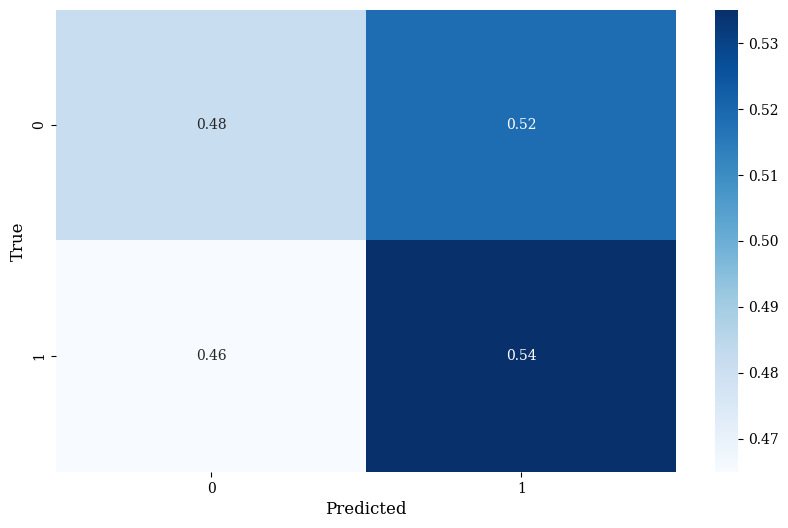

In [11]:
### Random Forest Classifier Test
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(data), 
                                random_state=42, 
                                max_depth=3)

# train the model
y_pred = fit_test_model(forest,X_train,y_train,X_test,y_test)

## Features Transform

In [14]:
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

### Brief EDA of Features Transform Samples

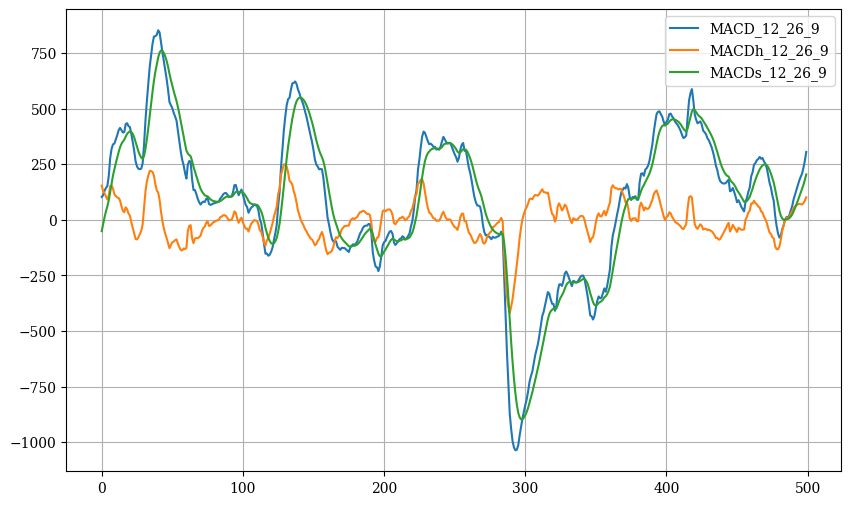

In [15]:
df_t_plain = pd.DataFrame(X_train[-500:,:],columns=data.iloc[:,idx].columns)
df_t_plain.plot();

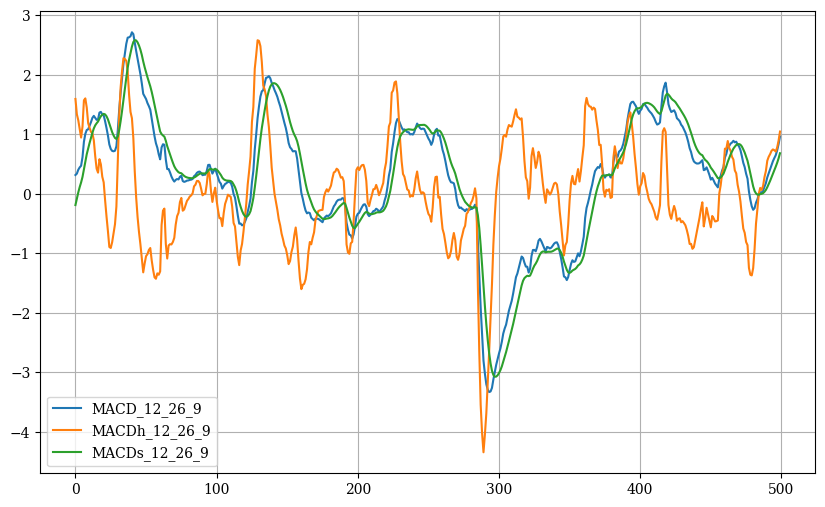

In [16]:
df_t_std = pd.DataFrame(X_train_std[-500:,:],columns=data.iloc[:,idx].columns)
df_t_std.plot();

In [17]:
dg = {}
dg_ = {}
seqlen = 21
dg['std'] = TimeseriesGenerator(X_train_std, y_train, length=seqlen)
dg_['std'] = TimeseriesGenerator(X_test_std, y_test, length=seqlen)

In [25]:
hp1 = {'units1': 12,
        'units2': 24,
        'Dropout_rate': 0.1,
        'learning_rate': 0.001,
        'activation': 'relu'}
hp2 = {'units1': 12,
        'units2': 24,
        'units3': 20,
        'Dropout_rate': 0.1,
        'learning_rate': 0.001,
        'activation': 'relu'}
dmodel = {}
dhistory = {}
dypred = {}
dyprob = {}

## Build Model

### Model 1

With the StandardScaler transform seems that the model learns in a quite good rate, however still struggles to learn fast at the beginning.

model: model1-std-loss
32/32 [==============================] - 1s 7ms/step


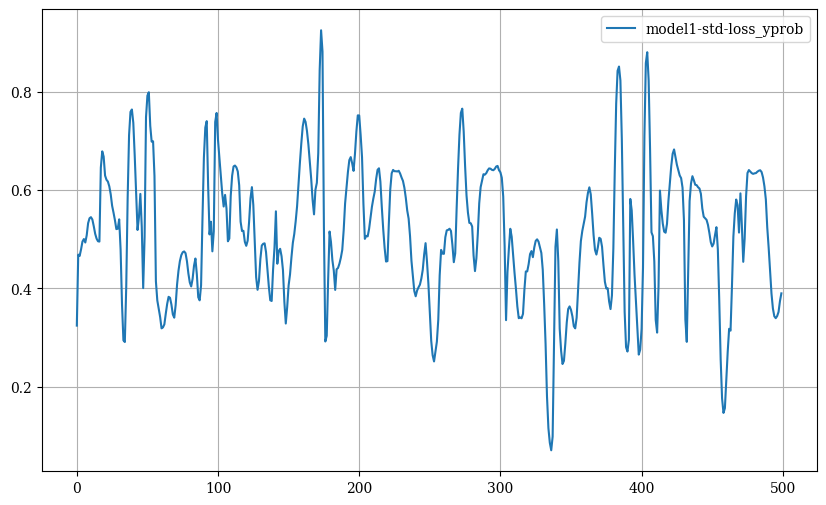

In [63]:
monitor = 'loss'
mname = 'std'
mtype = 'model1'
obs = ''
model_name = f'{mtype}-{mname}-{monitor}' if obs=='' else f'{mtype}-{mname}_{obs}-{monitor}'
print(f'model: {model_name}')

# numfeat = dg[mname].data.shape[1]

# dmodel[mname] = Model1(dg[mname],dg_[mname],seqlen,numfeat,class_weight,model_name=model_name)

# dmodel[mname].set_fit(es_monitor=monitor)

# dmodel[mname].create_model_best_hp(hp1)

# dhistory[model_name], dypred[model_name] = dmodel[mname].run_fit()

# dmodel[mname].plot_acc_loss(model_name,plot_val=True)

# loading model
dmodel[mname] = load_model(f"results/lstm_time_series/{model_name}.h5")
dyprob[mname] = dmodel[mname].predict(dg_[mname], verbose=True)
dypred[mname] = np.where(dyprob[mname] > 0.5, 1, 0)
df_prob = pd.DataFrame(dyprob[mname][-500:,:],columns=[f'{model_name}_yprob'])
df_prob.plot();

<AxesSubplot:>

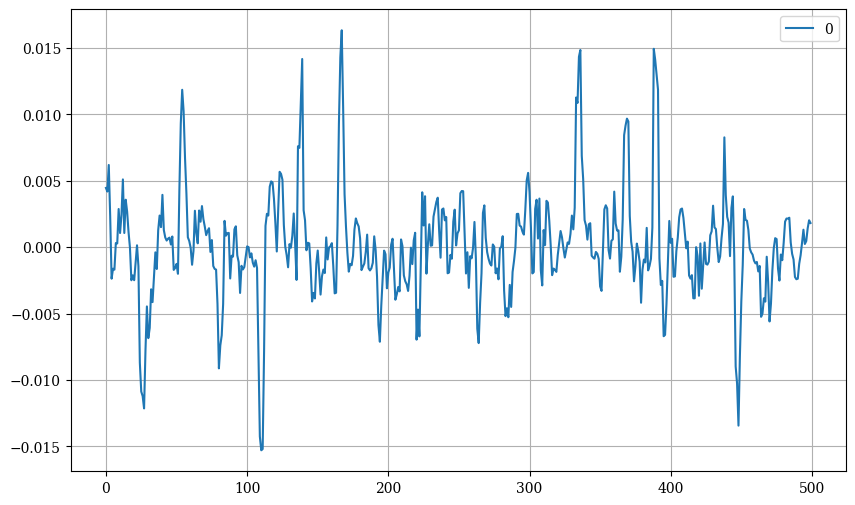

In [70]:
pd.DataFrame(data.iloc[-500:,-1].values).plot()

In [47]:
df_prob

,model1-std-loss_yprob
0,0.3242
1,0.4688
2,0.4662
3,0.4795
4,0.4954
...,...
495,0.3394
496,0.3436
497,0.3521
498,0.3741


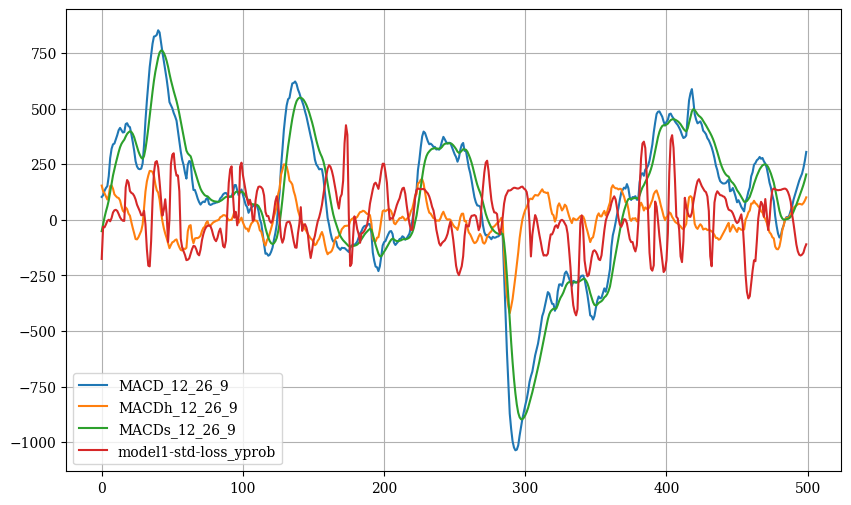

In [62]:
pd.concat([df_t_plain,((df_prob-.5)*1000)],axis=1).plot();

Interesting to observe how the model learned creating different patterns, anticipating possible trends. This can be better studied by using OOS data.

In [78]:
data

,Open,High,Low,Close,Volume,PCTRET_1,PCTRET_2,PCTRET_3,PCTRET_4,PCTRET_5,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,predict,predict_PCTRET_4
Date,,,,,,,,,,,,,,,
2020-11-06 10:00:00,"100,750.5900","100,750.5900","99,909.0500","99,909.0500",24141600,-0.0084,-0.0072,-0.0084,-0.0073,-0.0084,254.7888,-53.6220,308.4108,1,0.0062
2020-11-06 10:15:00,"99,865.6600","100,057.5700","99,837.0400","99,924.2300",41325600,0.0002,-0.0082,-0.0070,-0.0082,-0.0072,196.3123,-89.6787,285.9911,1,0.0066
2020-11-06 10:30:00,"99,926.0700","100,305.4000","99,926.0700","100,211.3800",37516300,0.0029,0.0030,-0.0054,-0.0042,-0.0054,171.1668,-91.8594,263.0262,1,0.0014
2020-11-06 10:45:00,"100,158.8700","100,853.7700","100,146.7300","100,787.4100",50300300,0.0057,0.0086,0.0088,0.0004,0.0015,195.4665,-54.0478,249.5143,0,-0.0053
2020-11-06 11:00:00,"100,797.0400","100,832.6000","100,351.0900","100,524.2100",33228900,-0.0026,0.0031,0.0060,0.0062,-0.0023,191.2811,-46.5866,237.8676,1,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28 14:45:00,"119,829.9800","119,982.9300","119,790.9800","119,940.2600",25465400,0.0012,0.0008,-0.0008,-0.0013,-0.0012,-189.7859,25.2582,-215.0442,1,0.0002
2023-07-28 15:00:00,"119,965.7400","120,047.7000","119,942.3500","119,961.7200",21082200,0.0002,0.0013,0.0010,-0.0006,-0.0011,-180.2328,27.8491,-208.0819,1,0.0005
2023-07-28 15:15:00,"119,959.5400","119,983.2800","119,883.8400","119,883.8400",18863200,-0.0006,-0.0005,0.0007,0.0003,-0.0013,-176.9069,24.9400,-201.8469,1,0.0014


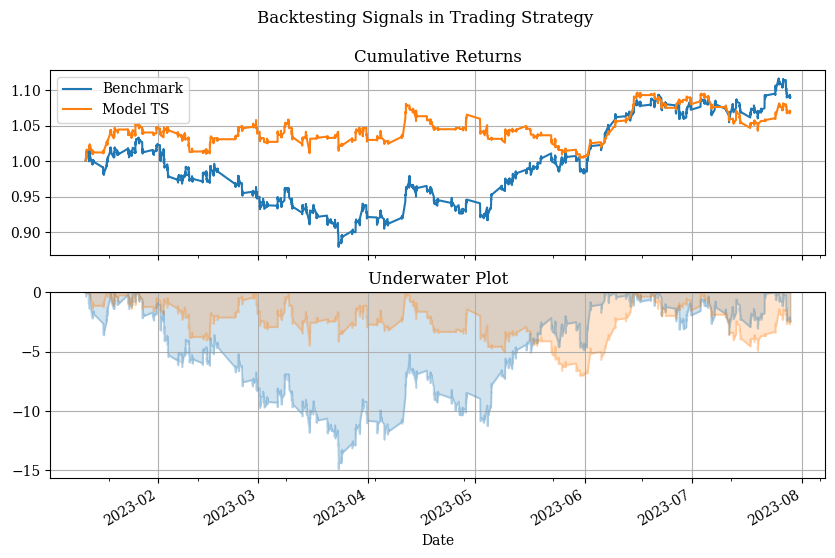

In [81]:
# backtest
pd.options.display.float_format = '{:,.4f}'.format
load_def_plot()

df_bt = pd.DataFrame(data.iloc[-dg_['std'].end_index+(dg_['std'].start_index-1):,[5]])
df_bt['y_pred'] = dypred[mname][:,0]
df_bt['ts_logret'] = df_bt['PCTRET_1'] * df_bt['y_pred']
df_bt.rename(columns={'PCTRET_1':'Benchmark',
                      'ts_logret':'Model TS'},
                      inplace=True)

# Simple tear sheet
# pf.create_simple_tear_sheet(df_bt['Model TS'])

df_bt['Underwater Benchmark'] = compute_underwater(df_bt['Benchmark'])
df_bt['Underwater Model TS'] = compute_underwater(df_bt['Model TS'])

fig, ax = plt.subplots(2,1)
fig.suptitle('Backtesting Signals in Trading Strategy')
ax[0] = plt.subplot(2,1,1)
df_bt[['Benchmark','Model TS']].cumsum().apply(np.exp).plot(ax=ax[0],kind='line', title='Cumulative Returns');
ax[1] = plt.subplot(2,1,2,sharex=ax[0])
df_bt['Underwater Benchmark'].plot(ax=ax[1],kind='area', alpha=0.2, title='Underwater Plot',label='Benchmark')
df_bt['Underwater Model TS'].plot(ax=ax[1],kind='area', alpha=0.2,label='Model TS');

At this moment let's check how to authors managed to get a good accuracy.

#### Analysis in OOS data:

In [56]:
df_oos.ta.strategy(MACD_Strategy,timed=True,verbose=True)
data_oos = df_oos.copy().dropna()

[+] Strategy: MACD Features
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Multiprocessing 6 indicators with 7 chunks and 8/8 cpus.
[i] Total indicators: 6
[i] Columns added: 0
[i] Last Run: Tuesday August 29, 2023, NYSE: 18:34:15, Local: 22:34:15 E. South America Standard Time, Day 241/365 (66.00%)
[i] Runtime: 1246.5155 ms (1.2465 s)


In [59]:
indic = 'MACD'
idx = data_oos.columns.str[:4].isin([indic])
data_oos.iloc[:,idx]

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2023-02-08 11:15:00,-42.3697,-67.9540,25.5843
2023-02-08 11:30:00,-80.4372,-84.8172,4.3800
2023-02-08 11:45:00,-143.5677,-118.3582,-25.2095
2023-02-08 12:00:00,-166.4139,-112.9635,-53.4504
2023-02-08 12:15:00,-162.6485,-87.3585,-75.2900
...,...,...,...
2023-11-08 15:45:00,-284.4727,-67.6330,-216.8396
2023-11-08 16:00:00,-277.6668,-48.6618,-229.0051
2023-11-08 16:15:00,-253.0939,-19.2710,-233.8228


### Model 2

In [ ]:
monitor = 'loss'
mname = 'std'
mtype = 'model2'
obs = ''
model_name = f'{mtype}-{mname}-{monitor}' if obs=='' else f'{mtype}-{mname}_{obs}-{monitor}'
print(f'model: {model_name}')

model: model2-std-loss
Settings model_path: results/lstm_time_series/model2-std-loss.h5
Settings logdir: ./tensorboard/logs\20230824_190034-model2-std-loss
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 21, 12)            768       
_________________________________________________________________
Drouput_1 (Dropout)          (None, 21, 12)            0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 24)                3552      
_________________________________________________________________
Output (Dense)               (None, 1)                 25        
Total params: 4,345
Trainable params: 4,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
125/125 [==============================] - 7s 32ms/step - loss: 0.6939 - accuracy: 0

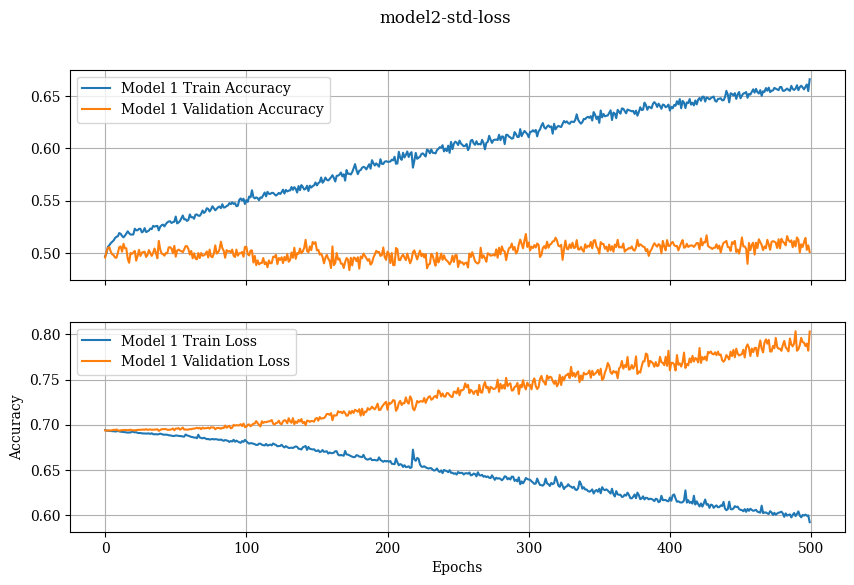

In [24]:
# numfeat = dg[mname].data.shape[1]

# dmodel[mname] = Model1(dg[mname],dg_[mname],seqlen,numfeat,class_weight,model_name=model_name)

# dmodel[mname].set_fit(es_monitor=monitor)

# dmodel[mname].create_model_best_hp(hp1)

# dhistory[model_name], dypred[model_name] = dmodel[mname].run_fit()

# dmodel[mname].plot_acc_loss(model_name,plot_val=True)

In [ ]:
# loading model
dmodel[mname] = load_model(f"results/lstm_time_series/{model_name}.h5")
dyprob[mname] = dmodel[mname].predict(dg_[mname], verbose=True)
dypred[mname] = np.where(dyprob[mname] > 0.5, 1, 0)
df_prob = pd.DataFrame(dyprob[mname][-500:,:],columns=[f'{model_name}_yprob'])
df_prob.plot();

The Model 2 transformed with StandardScaler seems to have the best trained model accuracy, however both Model 1 Std and Model 2 Std indicates that overfitting might be occuring duw to features inputs. 

But, still, would be nice to see how the prob predictions would look like for OOS data.